In [1]:
import tensorflow as tf
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
path = "/content/drive/MyDrive/DL/YAMNET/DatasetV2/"
with open(path + 'X.pkl', 'rb') as f:
    loaded_array = pickle.load(f)

X = loaded_array

with open(path + 'y.pkl', 'rb') as f:
    loaded_array = pickle.load(f)

y = loaded_array

In [4]:
X[0].shape

TensorShape([124, 1024])

In [5]:
print("len(X):", len(X))
print("len(y):", len(y))

len(X): 2272
len(y): 2272


In [6]:
num_classes = 5
y = tf.keras.utils.to_categorical(y, num_classes)

In [7]:
y[2000]

array([0., 0., 0., 0., 1.], dtype=float32)

In [8]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [9]:
print("len(X_train):", len(X_train))
print("len(X_test):", len(X_test))
print("len(y_train):", len(y_train))
print("len(y_test):", len(y_test))

len(X_train): 1817
len(X_test): 455
len(y_train): 1817
len(y_test): 455


In [10]:
X_train = np.array(X_train)
X_test = np.array(X_test)
y_train = np.array(y_train)
y_test = np.array(y_test)

In [11]:
import tensorflow as tf
from tensorflow.keras import regularizers, layers, models



model = models.Sequential([
    layers.Input(shape=(124, 1024), dtype=tf.float32, name='input_embedding'),
    layers.Flatten(),
    layers.Dense(1024, kernel_regularizer=regularizers.l2(0.003)),
    layers.BatchNormalization(),
    layers.ELU(),
    layers.Dropout(0.5),
    layers.Dense(512, kernel_regularizer=regularizers.l2(0.003)),
    layers.BatchNormalization(),
    layers.ELU(),
    layers.Dropout(0.5),
    layers.Dense(256, kernel_regularizer=regularizers.l2(0.003)),
    layers.BatchNormalization(),
    layers.ELU(),
    layers.Dropout(0.5),
    layers.Dense(128, kernel_regularizer=regularizers.l2(0.003)),
    layers.BatchNormalization(),
    layers.ELU(),
    layers.Dropout(0.5),
    layers.Dense(5, activation='softmax')
], name='yamnet_model')


# learning_rate = 0.001
# lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
#     initial_learning_rate=0.001,
#     decay_steps=1000,
#     decay_rate=0.96,
#     staircase=True)

# optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)


# Compile the model
optimizer = tf.keras.optimizers.Adam(learning_rate=0.00005)

METRICS = [
    'accuracy',
    tf.keras.metrics.Precision(name='precision'),
    tf.keras.metrics.Recall(name='recall')
]

model.compile(
              optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=METRICS)


model.summary()

Model: "yamnet_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 126976)            0         
                                                                 
 dense (Dense)               (None, 1024)              130024448 
                                                                 
 batch_normalization (Batch  (None, 1024)              4096      
 Normalization)                                                  
                                                                 
 elu (ELU)                   (None, 1024)              0         
                                                                 
 dropout (Dropout)           (None, 1024)              0         
                                                                 
 dense_1 (Dense)             (None, 512)               524800    
                                                      

In [12]:
from tensorflow.keras.callbacks import EarlyStopping

EPOCHS = 30
early_stopping = EarlyStopping(monitor='val_accuracy', patience=EPOCHS//3, restore_best_weights=True)
history = model.fit(X_train, y_train, epochs=EPOCHS, validation_data = (X_test, y_test), batch_size=64,callbacks=[early_stopping])

Epoch 1/30
29/29 [==============================] - 12s 192ms/step - loss: 11.4216 - accuracy: 0.3330 - precision: 0.3685 - recall: 0.2251 - val_loss: 11.3774 - val_accuracy: 0.3714 - val_precision: 0.4107 - val_recall: 0.3385
Epoch 2/30
29/29 [==============================] - 3s 106ms/step - loss: 10.8288 - accuracy: 0.4876 - precision: 0.5535 - recall: 0.3759 - val_loss: 10.7165 - val_accuracy: 0.5121 - val_precision: 0.5628 - val_recall: 0.4527
Epoch 3/30
29/29 [==============================] - 3s 99ms/step - loss: 10.4744 - accuracy: 0.5729 - precision: 0.6545 - recall: 0.4722 - val_loss: 10.3648 - val_accuracy: 0.5912 - val_precision: 0.6223 - val_recall: 0.5143
Epoch 4/30
29/29 [==============================] - 3s 97ms/step - loss: 10.2171 - accuracy: 0.6318 - precision: 0.6989 - recall: 0.5289 - val_loss: 10.0970 - val_accuracy: 0.6615 - val_precision: 0.7026 - val_recall: 0.6022
Epoch 5/30
29/29 [==============================] - 3s 100ms/step - loss: 9.9133 - accuracy: 0.70

In [13]:
# fig, ax = plt.subplots(2,1)
# ax[0].plot(history.history['loss'], color='b', label="Training Loss")
# ax[0].plot(history.history['val_loss'], color='r', label="Validation Loss",axes =ax[0])
# legend = ax[0].legend(loc='best', shadow=True)

# ax[1].plot(history.history['accuracy'], color='b', label="Training Accuracy")
# ax[1].plot(history.history['val_accuracy'], color='r',label="Validation Accuracy")
# legend = ax[1].legend(loc='best', shadow=True)

In [14]:
evaluation = model.evaluate(X_test, y_test)
print(f'Test Accuracy : {evaluation[1] * 100:.2f}%')

15/15 [==============================] - 0s 14ms/step - loss: 7.0108 - accuracy: 0.8022 - precision: 0.8249 - recall: 0.7868
Test Accuracy : 80.22%


15/15 [==============================] - 0s 10ms/step


<Axes: >

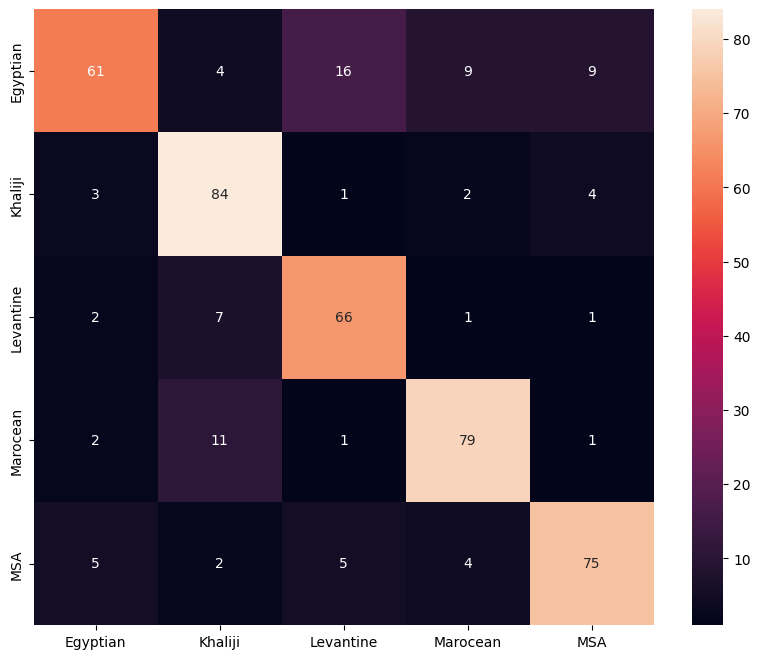

In [15]:
class_names = ["Egyptian", "Khaliji", "Levantine", "Marocean", "MSA"]

# Predict the values from the testing dataset
Y_pred = model.predict(X_test)
# Convert predictions classes to one hot vectors
Y_pred_classes = np.argmax(Y_pred,axis = 1)
# Convert testing observations to one hot vectors
Y_true = np.argmax(y_test,axis = 1)
# compute the confusion matrix
confusion_mtx = tf.math.confusion_matrix(Y_true, Y_pred_classes)

plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx, annot=True, fmt='g',xticklabels=class_names, yticklabels=class_names)

In [16]:
from sklearn.metrics import classification_report
print(classification_report(Y_true, Y_pred_classes))

              precision    recall  f1-score   support

           0       0.84      0.62      0.71        99
           1       0.78      0.89      0.83        94
           2       0.74      0.86      0.80        77
           3       0.83      0.84      0.84        94
           4       0.83      0.82      0.83        91

    accuracy                           0.80       455
   macro avg       0.80      0.81      0.80       455
weighted avg       0.81      0.80      0.80       455



In [17]:
# model.save(path+'yamnet_model40.h5')

In [18]:
# model = tf.keras.models.load_model('yamnet_model.h5')

In [20]:
with open(path+'X_test2.pkl', 'rb') as f:
    loaded_array = pickle.load(f)

X = loaded_array

with open(path+'y_test2.pkl', 'rb') as f:
    loaded_array = pickle.load(f)

y = loaded_array

print("len(X):", len(X))
print("len(y):", len(y))

X = np.array(X)
y = np.array(y)

len(X): 456
len(y): 456


In [21]:
NUM_CLASSES = 5
y = tf.keras.utils.to_categorical(y, NUM_CLASSES)

In [22]:
evaluation = model.evaluate(X, y)
print(f'Test Accuracy : {evaluation[1] * 100:.2f}%')

15/15 [==============================] - 0s 16ms/step - loss: 8.7363 - accuracy: 0.4605 - precision: 0.4789 - recall: 0.4474
Test Accuracy : 46.05%


15/15 [==============================] - 0s 14ms/step


<Axes: >

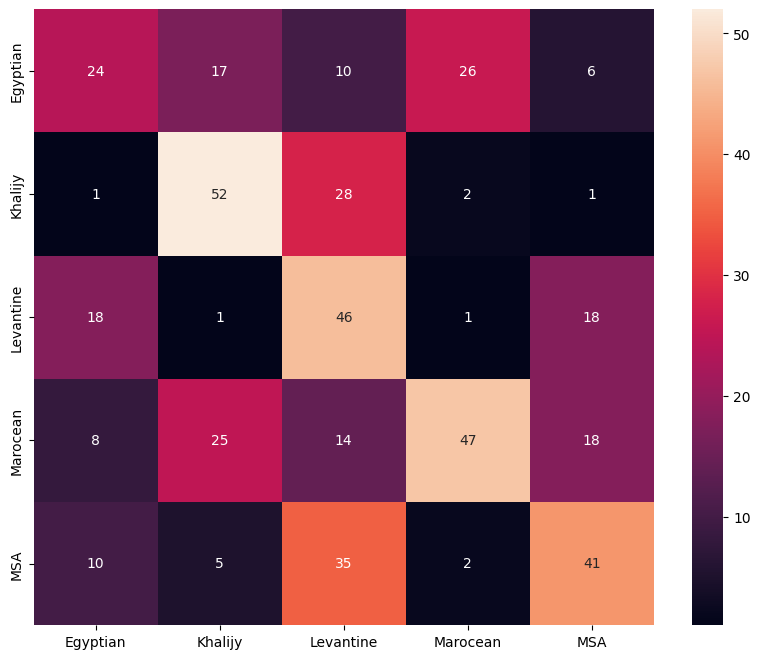

In [23]:
class_names = ["Egyptian", "Khalijy", "Levantine", "Marocean", "MSA"]

# Predict the values from the testing dataset
Y_pred = model.predict(X)
# Convert predictions classes to one hot vectors
Y_pred_classes = np.argmax(Y_pred,axis = 1)
# Convert testing observations to one hot vectors
Y_true = np.argmax(y,axis = 1)
# compute the confusion matrix
confusion_mtx = tf.math.confusion_matrix(Y_true, Y_pred_classes)

plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx, annot=True, fmt='g',xticklabels=class_names, yticklabels=class_names)

In [24]:
from sklearn.metrics import classification_report
print(classification_report(Y_true, Y_pred_classes))

              precision    recall  f1-score   support

           0       0.39      0.29      0.33        83
           1       0.52      0.62      0.57        84
           2       0.35      0.55      0.42        84
           3       0.60      0.42      0.49       112
           4       0.49      0.44      0.46        93

    accuracy                           0.46       456
   macro avg       0.47      0.46      0.46       456
weighted avg       0.48      0.46      0.46       456

